In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_csv("ic.csv")

In [3]:
df.head()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,gender,capital-gains,capital-loss,incident_severity,incident_city,damage_property,bodily_injuries,witnesses,police_reported,total_claim_amount,fraud,auto_year
0,328,48,521585,1000,1406.91,1,53300,0,1,1,1,1,2,1,71610,1,2004
1,228,42,342868,2000,1197.22,1,0,0,2,2,0,0,0,0,5070,1,2007
2,134,29,687698,2000,1413.14,0,35100,0,2,1,0,2,3,0,34650,0,2007
3,256,41,227811,2000,1415.74,0,48900,-62400,1,3,0,1,2,0,63400,1,2014
4,228,44,367455,1000,1583.91,1,66000,-46000,2,3,0,0,1,0,6500,0,2009


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [5]:
target_name = 'fraud'
X = df.drop('fraud', axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=123, stratify=y)

In [6]:
def CMatrix(CM, labels=['non fraud','fraud']):
    data = pd.DataFrame(data = CM, index = labels, columns=labels)
    data.index.name = 'TRUE'
    df.columns.name = 'PREDICTION'
    data.loc['Total'] = data.sum()
    data['Total'] = data.sum(axis=1)
    return data
    

In [7]:
metrics = pd.DataFrame(index = ['accuracy','precision','recall'],
                       columns = ['NULL','LogisticReg'])

In [8]:
y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM= confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

C:\Users\Apurva\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,non fraud,fraud,Total
TRUE,,,
non fraud,151,0,151
fraud,49,0,49
Total,200,0,200


In [9]:
#LogisticRgression
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(n_jobs = -1, random_state = 15)
logistic_regression.fit(X_train, y_train)

y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred = y_pred_test, y_true = y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred = y_pred_test, y_true = y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred = y_pred_test, y_true = y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)


C:\Users\Apurva\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Apurva\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


,non fraud,fraud,Total
TRUE,,,
non fraud,139,12,151
fraud,36,13,49
Total,175,25,200


In [10]:
100*metrics

,NULL,LogisticReg
accuracy,75.5,76
precision,0,52
recall,0,26.5306


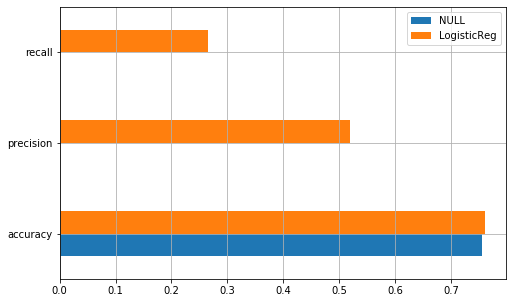

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

In [12]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test,
                                                                probas_pred = logistic_regression.predict_proba(X_test)[:,1])

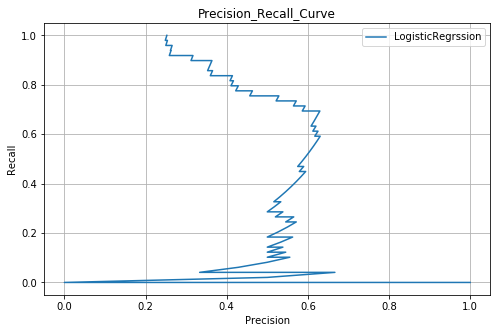

In [13]:
fig, ax=plt.subplots(figsize=(8,5))
ax.plot(precision_lr,recall_lr,label='LogisticRegrssion')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision_Recall_Curve')
ax.legend()
ax.grid();


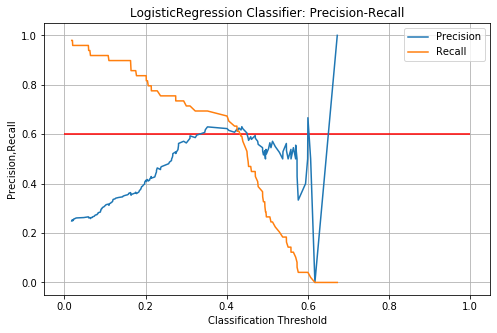

In [14]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds_lr, precision_lr[1:], label='Precision')
ax.plot(thresholds_lr, recall_lr[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision,Recall')
ax.set_title('LogisticRegression Classifier: Precision-Recall')
ax.hlines(y=0.6,xmin=0,xmax=1,color='red')
ax.legend()
ax.grid();

In [15]:
#Classifier with threshold 0.2
y_pred_proba = logistic_regression.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.2).astype('int')

#confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print("Recall: ", 100*recall_score(y_pred=y_pred_test, y_true=y_test))
print("Precision: ", 100*precision_score(y_pred=y_pred_test, y_true=y_test))
CMatrix(CM)

Recall:  83.6734693877551
Precision:  41.0


,non fraud,fraud,Total
TRUE,,,
non fraud,92,59,151
fraud,8,41,49
Total,100,100,200


In [16]:
#making individual predictions
def make_ind_predictions(new_data):
    data = new_data.values.reshape(1,-1)
    data = robust_scaler.transform(data) 
    prob = logistic_regression.predict_proba(data)[0][1]
    if prob >= 0.2:
        return 'fraud'
    else:
        return 'non fraud'    

In [17]:
nonfraud = df[df['fraud'] == 0]

In [18]:
nonfraud.head()

PREDICTION,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,gender,capital-gains,capital-loss,incident_severity,incident_city,damage_property,bodily_injuries,witnesses,police_reported,total_claim_amount,fraud,auto_year
2,134,29,687698,2000,1413.14,0,35100,0,2,1,0,2,3,0,34650,0,2007
4,228,44,367455,1000,1583.91,1,66000,-46000,2,3,0,0,1,0,6500,0,2009
6,137,34,413978,1000,1333.35,1,0,-77000,2,5,0,0,0,0,78650,0,2012
7,165,37,429027,1000,1137.03,1,0,0,3,1,0,2,2,1,51590,0,2015
8,27,33,485665,500,1442.99,0,0,0,3,3,0,1,1,1,27700,0,2012


In [20]:
from collections import OrderedDict
new_case = OrderedDict([('month_as_customer', 456),('age',60),('policy_number',556080),('policy_deductable',1000), 
                        ('policy_annual_premium',766.19),('gender',0),('capital-gains',0),('capital-loss',0),
                        ('incident_severity',2),('incident_city',1),('damage_property',0),('bodily_injuries',0),('witnesses',3),
                        ('police_reported',0),('total_claim_amount',5060),('auto_year',2007)])
new_case = pd.Series(new_case)
make_ind_predictions(new_case)


'non fraud'

In [21]:
from collections import OrderedDict
new_case = OrderedDict([('month_as_customer', 328),('age',48),('policy_number',521585),('policy_deductable',1000), 
                        ('policy_annual_premium',1406.91),('gender',1),('capital-gains',53300),('capital-loss',0),
                        ('incident_severity',1),('incident_city',1),('damage_property',1),('bodily_injuries',1),('witnesses',2),
                        ('police_reported',1),('total_claim_amount',71610),('auto_year',2004)])
new_case = pd.Series(new_case)
make_ind_predictions(new_case)

'fraud'

Feature: 0, Score: 0.13296
Feature: 1, Score: -0.25318
Feature: 2, Score: -0.19184
Feature: 3, Score: 0.07500
Feature: 4, Score: -0.09017
Feature: 5, Score: 0.09692
Feature: 6, Score: 0.00612
Feature: 7, Score: -0.07160
Feature: 8, Score: -2.31173
Feature: 9, Score: -0.00419
Feature: 10, Score: 0.11766
Feature: 11, Score: 0.18948
Feature: 12, Score: 0.06487
Feature: 13, Score: -0.17735
Feature: 14, Score: 0.21628
Feature: 15, Score: -0.02651


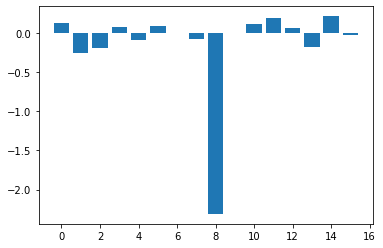

In [22]:
importance = logistic_regression.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [23]:
print(logistic_regression.coef_)

[[ 0.13295723 -0.25318002 -0.19184385  0.07500242 -0.090166    0.09692476
   0.00611622 -0.0716044  -2.311726   -0.00418967  0.117664    0.18947972
   0.06486946 -0.17735433  0.21628238 -0.02650886]]


In [24]:
from collections import OrderedDict
new_case = OrderedDict([('month_as_customer', 10),('age',20),('policy_number',298365),('policy_deductable',3000), 
                        ('policy_annual_premium',100),('gender',1),('capital-gains',40091),('capital-loss',0),
                        ('incident_severity',2),('incident_city',2),('damage_property',0),('bodily_injuries',1),('witnesses',0),
                        ('police_reported',0),('total_claim_amount',30000),('auto_year',2001)])
new_case = pd.Series(new_case)
make_ind_predictions(new_case)

'fraud'